In [2]:
# This notebook is a demo implementation for LDA Topic Analysis for news articles. 
# It uses the AllTheNews Dataset from Kaggle.
# https://www.kaggle.com/snapcrack/all-the-news
#
# You can adjust the type of vectorizer and the number of topics.
#
# The LDA algorithm is applied to both the title and the body of the article combined.
# It also narrows the dataset to June 1st, 2016 to June 5th 2016 as an example.
# For better NLP, punctuation, numbers, and stop words are removed 
# and all words are made to be lowercase.
#
# After LDA is applied, the first 5 words of the topic are printed, a heatmap 
# displays the strength of each topic and pyLDAvis is used to analyze the topics


import pandas as pd
import gdown
import nltk
import re

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
# Change Variables
vectorizer_type = "unigram" #unigram, bigram or tfidf
number_of_topics = 10 #5-15 reccomended

In [4]:
#Download AllTheNews Dataset
gdown.download('https://drive.google.com/uc?authuser=0&id=17uXa8XS4mfJB76B7Bz1GELEziVmVw2dB&export=download',
               'articlespart1.csv',
               quiet=False)
df1 = pd.read_csv('articlespart1.csv')

gdown.download('https://drive.google.com/uc?authuser=0&id=1f9xgkww5mHjB5a-UgMw8fvmcv1SgExFi&export=download',
               'articlespart2.csv',
               quiet=False)
df2 = pd.read_csv('articlespart2.csv')

gdown.download('https://drive.google.com/uc?authuser=0&id=1AQEgrR5fy8o9QpxHHngYvOO7enWEGtA1&export=download',
               'articlespart3.csv',
               quiet=False)
df3 = pd.read_csv('articlespart3.csv')

# Merge into one dataset
df = pd.concat([df1, df2, df3])

Downloading...
From: https://drive.google.com/uc?authuser=0&id=17uXa8XS4mfJB76B7Bz1GELEziVmVw2dB&export=download
To: /content/articlespart1.csv
192MB [00:01, 121MB/s]
Downloading...
From: https://drive.google.com/uc?authuser=0&id=1f9xgkww5mHjB5a-UgMw8fvmcv1SgExFi&export=download
To: /content/articlespart2.csv
214MB [00:02, 98.2MB/s]
Downloading...
From: https://drive.google.com/uc?authuser=0&id=1AQEgrR5fy8o9QpxHHngYvOO7enWEGtA1&export=download
To: /content/articlespart3.csv
258MB [00:02, 119MB/s]


In [11]:
# Delete rows with null titles, content, or dates
cleandf = df.dropna(subset=['title', 'content', 'date'])

# Sets the date as the index
dateSet = cleandf.set_index('date')

#Sorts the data by date
dateSort = dateSet.sort_index()

# Narrow the articles to within 5 days
timedf = dateSort.truncate('2016-06-01', '2016-06-05')

# Drop the extra columns
articles = timedf.drop(columns=['id', 'author', 'year','month', 'url'], axis=1)

# Combine the title with the article.
articles['combined_article'] = articles['title'] + " " + articles['content']

# Print articles
articles

,Unnamed: 0,title,publication,content,combined_article
date,,,,,
2016-06-01,30454,David French: I Will Vote for Donald Trump If ...,Breitbart,Bill Kristol’s pick David French said before t...,David French: I Will Vote for Donald Trump If ...
2016-06-01,73008,Department Of Justice And North Carolina Sue ...,Buzzfeed News,’ Here’s the DOJ’s lawsuit:’ ’ Here’s North Ca...,Department Of Justice And North Carolina Sue ...
2016-06-01,96261,Why is Chelsea Handler’s new show so awful?,New York Post,"Have you seen Chelsea lately? Since May 11, th...",Why is Chelsea Handler’s new show so awful? Ha...
2016-06-01,73007,How Did You Build Your Family As An LGBT Couple?,Buzzfeed News,’ LGBT parents have a few extra hurdles to jum...,How Did You Build Your Family As An LGBT Coup...
2016-06-01,97452,Dad jailed for making his daughter marry her r...,New York Post,"ST. ANTHONY, Idaho — An Idaho man will spend a...",Dad jailed for making his daughter marry her r...
...,...,...,...,...,...
2016-06-05,62085,"Gunmen kill Afghan prosecutor, 7 others in cou...",Fox News,Taliban gunmen stormed a court building in ea...,"Gunmen kill Afghan prosecutor, 7 others in cou..."
2016-06-05,27656,McConnell: ’I Am Concerned About the Hispanic ...,Breitbart,"Sunday on NBC’s “Meet the Press,” Sennate Majo...",McConnell: ’I Am Concerned About the Hispanic ...
2016-06-05,62084,"Veteran NPR journalist David Gilkey, translato...",Fox News,"David Gilkey, a veteran news photographer and...","Veteran NPR journalist David Gilkey, translato..."


In [6]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
#Format's the text to be processed by the LDA algorithm

def preprocess_text(s):
    if(type(s) == float):
      print(s)

    # substitute in a regular apostrophe for '’'
    s = s.replace('’', "'")

    # Remove punctuation
    s = re.sub(r'[^\w\s]','',s)
    s = re.sub('_','',s)

    # Remove numbers
    s = re.sub('[0-9]','',s)
    
    # Tokenize words
    s = word_tokenize(s)

    # Remove stop words
    s = [w for w in s if not w in stop_words]

    return " ".join(s)


In [8]:
# Remove punctuation, numbers and stop words
articles['formatted_article'] = articles['combined_article'].map(preprocess_text)

# Convert to lowercase
articles['formatted_article'] = articles['formatted_article'].map(lambda x: x.lower())

# Print out the first rows of papers
articles.head()

,Unnamed: 0,title,publication,content,combined_article,formatted_article
date,,,,,,
2016-06-01,30454,David French: I Will Vote for Donald Trump If ...,Breitbart,Bill Kristol’s pick David French said before t...,David French: I Will Vote for Donald Trump If ...,david french i will vote donald trump if he is...
2016-06-01,73008,Department Of Justice And North Carolina Sue ...,Buzzfeed News,’ Here’s the DOJ’s lawsuit:’ ’ Here’s North Ca...,Department Of Justice And North Carolina Sue ...,department of justice and north carolina sue e...
2016-06-01,96261,Why is Chelsea Handler’s new show so awful?,New York Post,"Have you seen Chelsea lately? Since May 11, th...",Why is Chelsea Handler’s new show so awful? Ha...,why chelsea handlers new show awful have seen ...
2016-06-01,73007,How Did You Build Your Family As An LGBT Couple?,Buzzfeed News,’ LGBT parents have a few extra hurdles to jum...,How Did You Build Your Family As An LGBT Coup...,how did you build your family as an lgbt coupl...
2016-06-01,97452,Dad jailed for making his daughter marry her r...,New York Post,"ST. ANTHONY, Idaho — An Idaho man will spend a...",Dad jailed for making his daughter marry her r...,dad jailed making daughter marry rapist st ant...


In [0]:
# Create a corpus of all of the formatted articles
corpus = []
for a in articles['formatted_article']: 
        corpus.append(a)

In [89]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 


# Vectorize the corpus of articles

def vectorize(type_of_vectorizer):
    if(type_of_vectorizer == "unigram"):
      # Unigram vectorizer
      vectorizer = CountVectorizer(stop_words= 'english', max_df = 0.5, min_df = 10)
      X = vectorizer.fit_transform(corpus)

    elif(type_of_vectorizer == "bigram"):
      # Vectorize with bigrams
      vectorizer = CountVectorizer(stop_words= 'english', ngram_range=(1, 2), max_df = 0.5, min_df = 10)
      X = vectorizer.fit_transform(corpus)

    else:
      # Vectorize with TF-IDF
      vectorizer = TfidfVectorizer(stop_words= 'english')
      X = vectorizer.fit_transform(corpus)

    return vectorizer, X

print(vectorizer_type)

vectorizer, X = vectorize(vectorizer_type)
# print(vectorizer.get_feature_names())

unigram


In [83]:
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

number_topics = number_of_topics
number_words = 5

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(X)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, vectorizer, number_words)

Topics found via LDA:

Topic #0:
police news killed twitter breitbart

Topic #1:
women time told life years

Topic #2:
eu drug european europe britain

Topic #3:
ali mr world muhammad alis

Topic #4:
says time know years dont

Topic #5:
trump trumps donald mr republican

Topic #6:
clinton sanders hillary campaign democratic

Topic #7:
state government law states court

Topic #8:
percent students year million years

Topic #9:
company years says way film


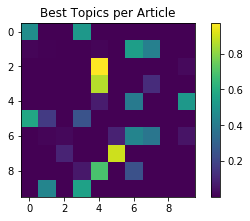

In [80]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the strength of each topic

H = lda.transform(X[0:10])
fig = plt.figure(figsize=(6, 3.2))
ax = fig.add_subplot(111)
im = ax.imshow(H)

# Add a colorbar
fig.colorbar(im, ax=ax)

ax.set_title('Best Topics per Article')

plt.imshow(H)
ax.set_aspect('equal')


plt.show()

In [15]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 9.7MB/s 
     |████████████████████████████████| 552kB 49.0MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=52a692070b04b75edf77bf7f8a4da42673a52b3d4e5b309c5f8c576455b00480
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32040 sha256=8cee67a323e121c4084218891bf03eef08f63267c79f1b178dbbd03f4a00928a
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [0]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [61]:
pyLDAvis.sklearn.prepare(lda, X, vectorizer)

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.005564 -0.032319       1        1  24.653838
0      0.086392 -0.177865       2        1  18.614734
2     -0.072726 -0.018055       3        1  11.143396
7     -0.111119 -0.040550       4        1   8.522156
5     -0.168781 -0.013736       5        1   8.361036
6     -0.018330  0.105831       6        1   8.240183
3      0.053496 -0.090591       7        1   7.952920
9      0.088292  0.202845       8        1   5.636508
1      0.217315  0.001293       9        1   3.877917
8     -0.068975  0.063148      10        1   2.997312, topic_info=     Category         Freq     Term        Total  loglift  logprob
7877  Default  4275.000000    trump  4275.000000  30.0000  30.0000
4840  Default  1594.000000       mr  1594.000000  29.0000  29.0000
1294  Default  2314.000000  clinton  2314.000000  28.0000  28.0000
238   Default   799.000000      ali   799.000000  27.0000  27.0000
6615  Default  1166.000000  sanders  1166.000000  26.0000  26.0000
...       ...          ...      ...          ...      ...      ...
4053  Topic10    51.807002     june   696.706182   0.9086  -5.7497
8479  Topic10    54.675773     year  1200.592456   0.4183  -5.6959
6258  Topic10    49.961254   report   592.566121   1.0342  -5.7860
109   Topic10    46.855775    added   389.909890   1.3886  -5.8502
4802  Topic10    41.425483   months   499.452725   1.0178  -5.9734

[749 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4         9  0.922026      abbott
48        1  0.054236   according
48        2  0.121165   according
48        3  0.105010   according
48        4  0.088855   according
...     ...       ...         ...
8521      7  0.010631       youre
8521      9  0.029234       youre
8529      3  0.956125  zabihullah
8537      1  0.993953         zoo
8538      1  0.990651        zoos

[2624 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 3, 8, 6, 7, 4, 10, 2, 9])